### PCA

In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import plotly.express as px

In [258]:
# df = pd.read_csv("Datasets/preprocessed_dataset.csv")
df = pd.read_csv("Datasets/new_dataset_added_column_scaled.csv")

In [259]:
df = df.drop(["Unnamed: 0","id"],axis=1)

In [260]:
df=df[df['hospital_length_of_stay']<20]

### Splitting X and y

In [261]:
from sklearn.model_selection import train_test_split
X = df.drop("hospital_length_of_stay",axis =1)
y = df['hospital_length_of_stay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (292, 782)
X_test shape: (126, 782)
y_train shape: (292,)
y_test shape: (126,)


### Implenting lasso regression to the original dataset

In [262]:
from sklearn.linear_model import Lasso, Ridge

# Apply Lasso Regression
lasso = Lasso(alpha=0.1)  # Specify the regularization parameter alpha
lasso.fit(X_train, y_train)

# Make predictions
y_pred = lasso.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 22.244229326126572


### Applying PCA to reduce to a certain dimension capturing 80 percent variance

In [263]:
pca = PCA(n_components = 50)
# Transform data
pca_trans = pca.fit_transform(X)     
print(pca_trans)                                                  
print(pca_trans.shape) 

[[ 0.50297131  0.30457131 -0.66713948 ...  0.09164834 -0.04484008
   0.00834018]
 [ 1.01739137 -0.46152524 -0.55846008 ...  0.09348056  0.06478779
   0.1296592 ]
 [ 0.49671668 -2.08331246  0.7112468  ...  0.3676415  -0.19078871
   0.02713306]
 ...
 [ 0.79696765  5.20711518 -2.53739352 ... -0.1269005  -0.11273533
   0.09595769]
 [ 0.90242164 -2.09862896 -1.11194041 ... -0.14603451 -0.15989126
   0.05435707]
 [ 0.28636859 -2.11895139 -0.62738391 ... -0.25124389 -0.19147293
  -0.10624777]]
(418, 50)


Total variance captured: 0.9053995736790349


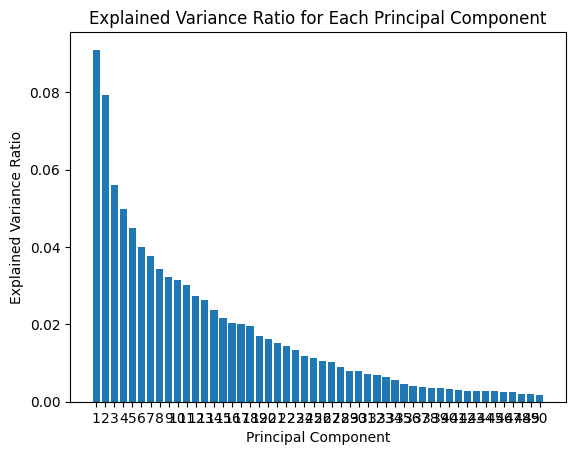

In [264]:
# Get the explained variance ratios for each principal component
explained_variance_ratios = pca.explained_variance_ratio_

# Print the explained variance ratios for each component
# print("Explained Variance Ratios for each component:")
# for i, var_ratio in enumerate(explained_variance_ratios):
#     print(f"Component {i+1}: {var_ratio}")
print("Total variance captured:",sum(explained_variance_ratios))
# Plotting the explained variance ratios
plt.bar(range(1, len(explained_variance_ratios) + 1), explained_variance_ratios, align='center')
plt.xticks(range(1, len(explained_variance_ratios) + 1))
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for Each Principal Component')
plt.show()

#### Applying lasso to the 80 percent variance captured pca components

In [265]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
import numpy as np

# Ensure pca_trans and y are NumPy arrays
pca_trans = np.array(pca_trans)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pca_trans, y, test_size=0.2, random_state=42)

# Initialize Lasso regression model with alpha=0.1
lasso = Lasso(alpha=0.1)

# Prepare KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store training MSE
train_mse_list = []

# Manual cross-validation on the training data
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Train model
    lasso.fit(X_train_fold, y_train_fold)
    
    # Predict on training data
    y_train_pred = lasso.predict(X_train_fold)
    
    # Calculate MSE for training data
    train_mse = mean_squared_error(y_train_fold, y_train_pred)
    
    # Append to list
    train_mse_list.append(train_mse)

# Convert to numpy array for convenience
train_mse_array = np.array(train_mse_list)

# Calculate mean and standard deviation
mean_train_mse = train_mse_array.mean()
std_train_mse = train_mse_array.std()

# Predict on the entire training set and calculate MSE
y_pred_train = lasso.predict(X_train)
## calculting MSE for train data
train_mse_full = mean_squared_error(y_train, y_pred_train)

# Print all the training MSE scores, mean, and standard deviation
print("Cross-validation training MSE scores:", train_mse_array)
print(f"Mean training MSE: {mean_train_mse}")
print(f"Standard deviation of training MSE: {std_train_mse}")
print(f"Training MSE on full training set: {train_mse_full}")


Cross-validation training MSE scores: [13.11211018 13.75437753 14.61625513 13.67989611 14.43895067]
Mean training MSE: 13.920317925974638
Standard deviation of training MSE: 0.5462320286812539
Training MSE on full training set: 14.457564777990273


In [266]:
# Assuming pca_trans and y are already defined
X_train, X_test, y_train, y_test = train_test_split(pca_trans, y, test_size=0.2, random_state=42)

# Perform 5-fold cross-validation on the training data
cv_scores = cross_val_score(lasso, pca_trans, y, cv=5, scoring='neg_mean_squared_error')

# Fit the model on the entire training data
lasso.fit(X_train, y_train)

# Make predictions on training and test data
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

# Calculate Mean Squared Error for test data
mse_test = mean_squared_error(y_test, y_pred_test)

print("Cross-validation MSE scores:", -cv_scores)
print("Mean cross-validation MSE:", -np.mean(cv_scores))
print("Standard deviation of cross-validation MSE:", np.std(cv_scores))
print("Mean Squared Error for testing:", mse_test)

Cross-validation MSE scores: [22.31263888 20.12721462 18.11584241 20.81164166 17.18495433]
Mean cross-validation MSE: 19.710458378253318
Standard deviation of cross-validation MSE: 1.8481669025006429
Mean Squared Error for testing: 26.941030573896207


In [226]:
df_train = pd.DataFrame({'y_train': y_train, 'y_pred_train': y_pred_train})

# Create a scatter plot using Plotly Express
fig = px.scatter(df_train, x='y_train', y='y_pred_train', title='y_train vs y_pred_train')
fig.update_layout(xaxis_title='y_train', yaxis_title='y_pred_train')
fig.show()

df_test = pd.DataFrame({'y_test': y_test, 'y_pred_test': y_pred_test})

# Create a scatter plot using Plotly Express
fig = px.scatter(df_test, x='y_test', y='y_pred_test', color_discrete_sequence=['green'], title='y_test vs y_pred_test')
fig.update_layout(xaxis_title='y_test', yaxis_title='y_pred_test')
fig.show()

#### Applying Ridge regression with alpha 1

In [100]:
X_train, X_test, y_train, y_test = train_test_split(pca_trans, y, test_size=0.3, random_state=42)

ridge = Ridge(alpha=1)  
ridge.fit(X_train, y_train)
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)
mse_y_test = mean_squared_error(y_test, y_pred_test)
mse_y_train = mean_squared_error(y_train, y_pred_train)
print("Mean Squared Error train:", mse_y_train)
print("Mean Squared Error test:", mse_y_test)
df_train = pd.DataFrame({'y_train': y_train, 'y_pred_train': y_pred_train})

# Create a scatter plot using Plotly Express
fig = px.scatter(df_train, x='y_train', y='y_pred_train', title='y_train vs y_pred_train')
fig.update_layout(xaxis_title='y_train', yaxis_title='y_pred_train')
fig.show()

df_test = pd.DataFrame({'y_test': y_test, 'y_pred_test': y_pred_test})

# Create a scatter plot using Plotly Express
fig = px.scatter(df_test, x='y_test', y='y_pred_test', color_discrete_sequence=['green'], title='y_test vs y_pred_test')
fig.update_layout(xaxis_title='y_test', yaxis_title='y_pred_test')
fig.show()

Mean Squared Error train: 14.994968612025692
Mean Squared Error test: 24.025093653257688


#### Applying ridge regression with alpha 1000

In [101]:
X_train, X_test, y_train, y_test = train_test_split(pca_trans, y, test_size=0.3, random_state=42)

ridge = Ridge(alpha=1000)  
ridge.fit(X_train, y_train)
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)
mse_y_test = mean_squared_error(y_test, y_pred_test)
mse_y_train = mean_squared_error(y_train, y_pred_train)
print("Mean Squared Error train:", mse_y_train)
print("Mean Squared Error test:", mse_y_test)
df_train = pd.DataFrame({'y_train': y_train, 'y_pred_train': y_pred_train})

# Create a scatter plot using Plotly Express
fig = px.scatter(df_train, x='y_train', y='y_pred_train', title='y_train vs y_pred_train')
fig.update_layout(xaxis_title='y_train', yaxis_title='y_pred_train')
fig.show()

df_test = pd.DataFrame({'y_test': y_test, 'y_pred_test': y_pred_test})

# Create a scatter plot using Plotly Express
fig = px.scatter(df_test, x='y_test', y='y_pred_test', color_discrete_sequence=['green'], title='y_test vs y_pred_test')
fig.update_layout(xaxis_title='y_test', yaxis_title='y_pred_test')
fig.show()

Mean Squared Error train: 17.02901218135156
Mean Squared Error test: 22.343486028706675


### Applying PCA to reduce to a certain dimension capturing 85 percent variance

In [102]:
pca = PCA(n_components = 33)
# Transform data
pca_trans = pca.fit_transform(X)     
print(pca_trans)                                                  
print(pca_trans.shape) 

[[-0.50297131 -0.30457131  0.66713948 ... -0.46757685 -0.16094217
   1.35540743]
 [-1.01739137  0.46152524  0.55846008 ... -1.78409467  0.39831474
  -0.2630115 ]
 [-0.49671667  2.08331246 -0.71124679 ... -0.47589217  0.46668198
  -1.09189841]
 ...
 [-0.79696765 -5.20711518  2.53739352 ...  0.16012476  0.19666431
   0.39039952]
 [-0.90242164  2.09862896  1.11194041 ...  0.54784991 -0.07969431
   0.34031836]
 [-0.28636859  2.11895139  0.62738391 ... -0.08635008 -0.60789184
  -0.2317575 ]]
(418, 33)


Total variance captured: 0.8515042931640504


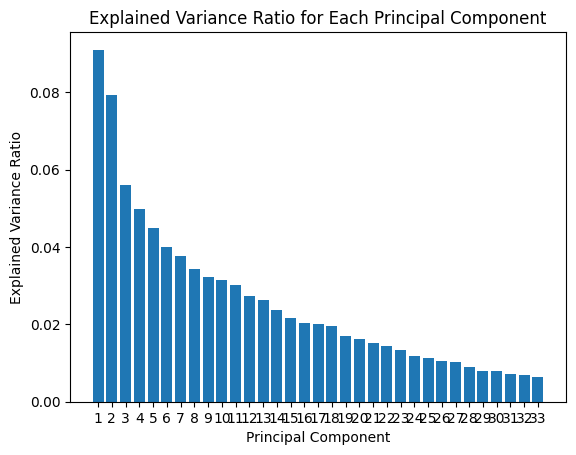

In [103]:
# Get the explained variance ratios for each principal component
explained_variance_ratios = pca.explained_variance_ratio_

print("Total variance captured:",sum(explained_variance_ratios))
# Plotting the explained variance ratios
plt.bar(range(1, len(explained_variance_ratios) + 1), explained_variance_ratios, align='center')
plt.xticks(range(1, len(explained_variance_ratios) + 1))
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for Each Principal Component')
plt.show()

#### Applying lasso to the 85 percent variance captured pca components

In [105]:
# Assuming pca_trans and y are already defined
X_train, X_test, y_train, y_test = train_test_split(pca_trans, y, test_size=0.3, random_state=42)

# Initialize Lasso regression model with alpha=1
lasso = Lasso(alpha=1)

# Perform 5-fold cross-validation on the training data
cv_scores = cross_val_score(lasso, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Fit the model on the entire training data
lasso.fit(X_train, y_train)

# Make predictions on training and test data
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

# Calculate Mean Squared Error for training and test data
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print("Cross-validation MSE scores:", -cv_scores)
print("Mean cross-validation MSE:", -np.mean(cv_scores))
print("Standard deviation of cross-validation MSE:", np.std(cv_scores))
print("Mean Squared Error for training:", mse_train)
print("Mean Squared Error for testing:", mse_test)

Cross-validation MSE scores: [19.72709364 19.58060206 18.59126381 16.25869374 18.02197901]
Mean cross-validation MSE: 18.435926452024102
Standard deviation of cross-validation MSE: 1.2580317481756533
Mean Squared Error for training: 18.263123944454872
Mean Squared Error for testing: 23.20186844519505


In [106]:
df_train = pd.DataFrame({'y_train': y_train, 'y_pred_train': y_pred_train})

# Create a scatter plot using Plotly Express
fig = px.scatter(df_train, x='y_train', y='y_pred_train', title='y_train vs y_pred_train')
fig.update_layout(xaxis_title='y_train', yaxis_title='y_pred_train')
fig.show()

df_test = pd.DataFrame({'y_test': y_test, 'y_pred_test': y_pred_test})

# Create a scatter plot using Plotly Express
fig = px.scatter(df_test, x='y_test', y='y_pred_test', color_discrete_sequence=['green'], title='y_test vs y_pred_test')
fig.update_layout(xaxis_title='y_test', yaxis_title='y_pred_test')
fig.show()

#### Applying ridge regression with alpha 1

In [107]:
X_train, X_test, y_train, y_test = train_test_split(pca_trans, y, test_size=0.3, random_state=42)

ridge = Ridge(alpha=1)  
ridge.fit(X_train, y_train)
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)
mse_y_test = mean_squared_error(y_test, y_pred_test)
mse_y_train = mean_squared_error(y_train, y_pred_train)
print("Mean Squared Error train:", mse_y_train)
print("Mean Squared Error test:", mse_y_test)
df_train = pd.DataFrame({'y_train': y_train, 'y_pred_train': y_pred_train})

# Create a scatter plot using Plotly Express
fig = px.scatter(df_train, x='y_train', y='y_pred_train', title='y_train vs y_pred_train')
fig.update_layout(xaxis_title='y_train', yaxis_title='y_pred_train')
fig.show()

df_test = pd.DataFrame({'y_test': y_test, 'y_pred_test': y_pred_test})

# Create a scatter plot using Plotly Express
fig = px.scatter(df_test, x='y_test', y='y_pred_test', color_discrete_sequence=['green'], title='y_test vs y_pred_test')
fig.update_layout(xaxis_title='y_test', yaxis_title='y_pred_test')
fig.show()

Mean Squared Error train: 14.541216848177315
Mean Squared Error test: 25.1300202050757


#### Applying Ridge regression with alpha 1000

In [108]:
X_train, X_test, y_train, y_test = train_test_split(pca_trans, y, test_size=0.3, random_state=42)

ridge = Ridge(alpha=1000)  
ridge.fit(X_train, y_train)
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)
mse_y_test = mean_squared_error(y_test, y_pred_test)
mse_y_train = mean_squared_error(y_train, y_pred_train)
print("Mean Squared Error train:", mse_y_train)
print("Mean Squared Error test:", mse_y_test)
df_train = pd.DataFrame({'y_train': y_train, 'y_pred_train': y_pred_train})

# Create a scatter plot using Plotly Express
fig = px.scatter(df_train, x='y_train', y='y_pred_train', title='y_train vs y_pred_train')
fig.update_layout(xaxis_title='y_train', yaxis_title='y_pred_train')
fig.show()

df_test = pd.DataFrame({'y_test': y_test, 'y_pred_test': y_pred_test})

# Create a scatter plot using Plotly Express
fig = px.scatter(df_test, x='y_test', y='y_pred_test', color_discrete_sequence=['green'], title='y_test vs y_pred_test')
fig.update_layout(xaxis_title='y_test', yaxis_title='y_pred_test')
fig.show()

Mean Squared Error train: 16.957141367622665
Mean Squared Error test: 22.322469861110104


### Applying PCA to reduce to a certain dimension capturing 90 percent variance

In [109]:
pca = PCA(n_components = 50)
# Transform data
pca_trans = pca.fit_transform(X)     
print(pca_trans)                                                  
print(pca_trans.shape) 

[[-0.50297131 -0.30457131  0.66713948 ...  0.09207025 -0.0312096
  -0.0359601 ]
 [-1.01739137  0.46152524  0.55846008 ...  0.09663329  0.04757809
  -0.18836745]
 [-0.49671668  2.08331246 -0.7112468  ...  0.4305876  -0.14450697
  -0.08839166]
 ...
 [-0.79696765 -5.20711518  2.53739352 ... -0.10938805 -0.1520338
  -0.05462057]
 [-0.90242164  2.09862896  1.11194041 ... -0.12520282 -0.16591331
  -0.04400653]
 [-0.28636859  2.11895138  0.62738391 ... -0.21649451 -0.19503939
   0.0988182 ]]
(418, 50)


Total variance captured: 0.9053728798530807


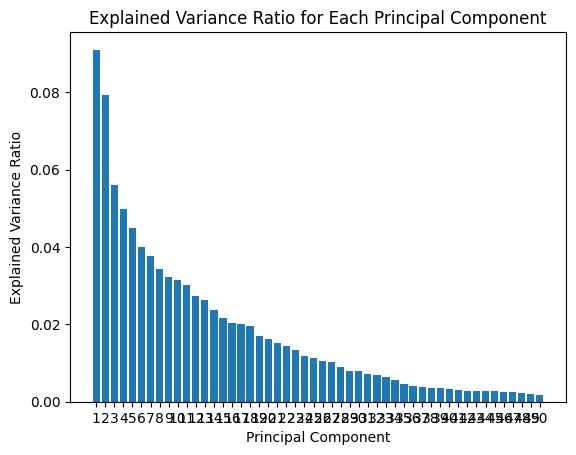

In [110]:
# Get the explained variance ratios for each principal component
explained_variance_ratios = pca.explained_variance_ratio_

print("Total variance captured:",sum(explained_variance_ratios))
# Plotting the explained variance ratios
plt.bar(range(1, len(explained_variance_ratios) + 1), explained_variance_ratios, align='center')
plt.xticks(range(1, len(explained_variance_ratios) + 1))
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for Each Principal Component')
plt.show()

#### Applying lasso to the 90 percent variance captured pca components

In [111]:
# Assuming pca_trans and y are already defined
X_train, X_test, y_train, y_test = train_test_split(pca_trans, y, test_size=0.3, random_state=42)

# Initialize Lasso regression model with alpha=1
lasso = Lasso(alpha=1)

# Perform 5-fold cross-validation on the training data
cv_scores = cross_val_score(lasso, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Fit the model on the entire training data
lasso.fit(X_train, y_train)

# Make predictions on training and test data
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

# Calculate Mean Squared Error for training and test data
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print("Cross-validation MSE scores:", -cv_scores)
print("Mean cross-validation MSE:", -np.mean(cv_scores))
print("Standard deviation of cross-validation MSE:", np.std(cv_scores))
print("Mean Squared Error for training:", mse_train)
print("Mean Squared Error for testing:", mse_test)

Cross-validation MSE scores: [19.72709364 19.58060206 18.59126381 16.25869374 18.02197901]
Mean cross-validation MSE: 18.435926452024102
Standard deviation of cross-validation MSE: 1.2580317481756533
Mean Squared Error for training: 18.263123944454872
Mean Squared Error for testing: 23.20186844519505


In [22]:
df_train = pd.DataFrame({'y_train': y_train, 'y_pred_train': y_pred_train})

# Create a scatter plot using Plotly Express
fig = px.scatter(df_train, x='y_train', y='y_pred_train', title='y_train vs y_pred_train')
fig.update_layout(xaxis_title='y_train', yaxis_title='y_pred_train')
fig.show()

df_test = pd.DataFrame({'y_test': y_test, 'y_pred_test': y_pred_test})

# Create a scatter plot using Plotly Express
fig = px.scatter(df_test, x='y_test', y='y_pred_test', color_discrete_sequence=['green'], title='y_test vs y_pred_test')
fig.update_layout(xaxis_title='y_test', yaxis_title='y_pred_test')
fig.show()

#### Applying ridge regression with alpha 1

In [23]:
X_train, X_test, y_train, y_test = train_test_split(pca_trans, y, test_size=0.3, random_state=42)

ridge = Ridge(alpha=1)  
ridge.fit(X_train, y_train)
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)
mse_y_test = mean_squared_error(y_test, y_pred_test)
mse_y_train = mean_squared_error(y_train, y_pred_train)
print("Mean Squared Error train:", mse_y_train)
print("Mean Squared Error test:", mse_y_test)
df_train = pd.DataFrame({'y_train': y_train, 'y_pred_train': y_pred_train})

# Create a scatter plot using Plotly Express
fig = px.scatter(df_train, x='y_train', y='y_pred_train', title='y_train vs y_pred_train')
fig.update_layout(xaxis_title='y_train', yaxis_title='y_pred_train')
fig.show()

df_test = pd.DataFrame({'y_test': y_test, 'y_pred_test': y_pred_test})

# Create a scatter plot using Plotly Express
fig = px.scatter(df_test, x='y_test', y='y_pred_test', color_discrete_sequence=['green'], title='y_test vs y_pred_test')
fig.update_layout(xaxis_title='y_test', yaxis_title='y_pred_test')
fig.show()

Mean Squared Error train: 9.24062026349798
Mean Squared Error test: 36.88424997516638


#### Applying ridge regression with alpha 1000

In [24]:
X_train, X_test, y_train, y_test = train_test_split(pca_trans, y, test_size=0.3, random_state=42)

ridge = Ridge(alpha=1000)  
ridge.fit(X_train, y_train)
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)
mse_y_test = mean_squared_error(y_test, y_pred_test)
mse_y_train = mean_squared_error(y_train, y_pred_train)
print("Mean Squared Error train:", mse_y_train)
print("Mean Squared Error test:", mse_y_test)
df_train = pd.DataFrame({'y_train': y_train, 'y_pred_train': y_pred_train})

# Create a scatter plot using Plotly Express
fig = px.scatter(df_train, x='y_train', y='y_pred_train', title='y_train vs y_pred_train')
fig.update_layout(xaxis_title='y_train', yaxis_title='y_pred_train')
fig.show()

df_test = pd.DataFrame({'y_test': y_test, 'y_pred_test': y_pred_test})

# Create a scatter plot using Plotly Express
fig = px.scatter(df_test, x='y_test', y='y_pred_test', color_discrete_sequence=['green'], title='y_test vs y_pred_test')
fig.update_layout(xaxis_title='y_test', yaxis_title='y_pred_test')
fig.show()

Mean Squared Error train: 18.449745661287654
Mean Squared Error test: 21.110874803699886
